In [1]:
from lsf_convolve_rplesha import read_lsf
import lsf_convolve_rplesha as conv

In [20]:
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import glob

from astroquery.mast import Observations

In [3]:
lsf, pix, w = conv.read_lsf('./data/aa_LSFTable_G130M_1291_LP3_cn.dat')

In [4]:
!mkdir data
data_dir = 'data/'
!mkdir output
output_dir = 'output/'

mkdir: data: File exists
mkdir: output: File exists


In [5]:
Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lcn502010')),
                               mrp_only = True)
for file in glob.glob('mast*/**/*fits', recursive = True):
    os.rename(file, data_dir+os.path.basename(file))

In [6]:
X = np.linspace(1100,1500, int(1E4))
voigt_shape = ap.modeling.functional_models.Voigt1D(x_0 = 1320, amplitude_L = 2E-12, fwhm_G = .1, fwhm_L = 0.05) 
Y = voigt_shape(X)

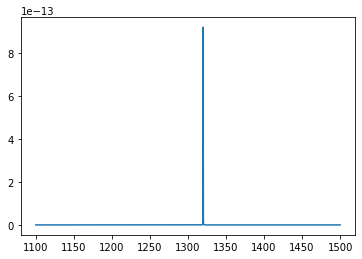

In [7]:
plt.plot(X, Y)
# plt.xlim(np.mean(X) -10,np.mean(X) +10)

In [8]:
specfile = glob.glob(data_dir+'*x1dsum.f*')[0]
cenwave = ap.io.fits.getheader(specfile)['CENWAVE']
wvln = np.concatenate((ap.table.Table.read(specfile)['WAVELENGTH'][1], ap.table.Table.read(specfile)['WAVELENGTH'][0]))
flux = np.concatenate((ap.table.Table.read(specfile)['FLUX'][1], ap.table.Table.read(specfile)['FLUX'][0]))
dqw = np.array(np.concatenate((ap.table.Table.read(specfile)['DQ_WGT'][1], ap.table.Table.read(specfile)['DQ_WGT'][0])), dtype = bool)

wvln, flux = wvln[dqw], flux[dqw] # trim to just the non-0 weighted points

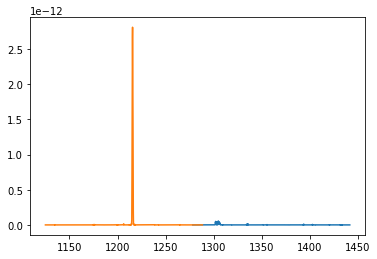

In [9]:
wtab = ap.table.Table.read(specfile)['WAVELENGTH']
ftab = ap.table.Table.read(specfile)['FLUX']
for i in range(2):
    plt.plot(wtab[i], ftab[i])

In [11]:
voigt_shape = ap.modeling.functional_models.Voigt1D(x_0 = 1320, amplitude_L = 2E-12, fwhm_G = .1, fwhm_L = 0.05) 
lwvln, lflux = conv.convolve_lsf(wvln, flux + voigt_shape(wvln), cenwave, './data/aa_LSFTable_G130M_1291_LP3_cn.dat', './05i1639ml_disp.fits')

In [13]:
np.shape(lwvln), np.shape(lflux)

((30247,), (30247,))

In [12]:
np.size(wvln) , np.size(lwvln)

(29342, 30247)

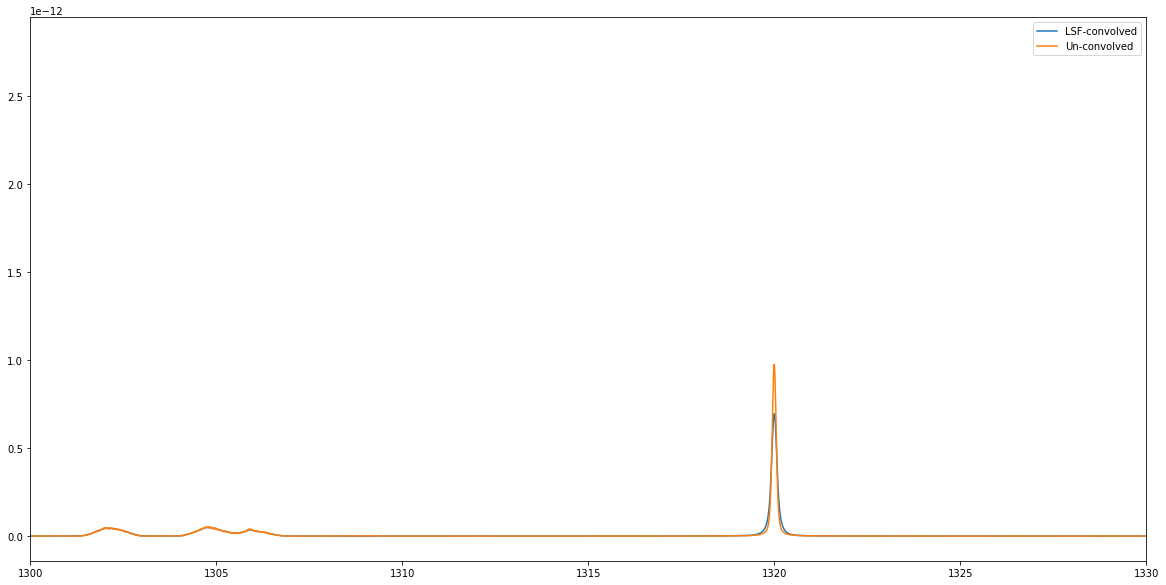

In [14]:
plt.figure(figsize = (20,10))

plt.plot(lwvln, lflux, label = 'LSF-convolved')
plt.plot(wvln, voigt_shape(wvln)+flux, label = 'Un-convolved')
# plt.plot(wvln, flux, alpha = 0.1)
# plt.xlim(1300,1320)
# plt.ylim(0,2E-15)
plt.xlim(1300,1330)
# plt.ylim(0,2E-15)
plt.legend()

In [ ]:
plt.plot(wvln,np.interp(wvln, lwvln, lflux) - (voigt_shape(wvln)+flux))

combo_flux = np.zeros(np.size(wvln))
lsf_combo_flux = np.zeros(np.size(lwvln))

for discrete_wvln in np.arange(int(min(wvln)+5), max(wvln)-5, 40):
    voigt_shape = ap.modeling.functional_models.Voigt1D(x_0 = discrete_wvln, amplitude_L = 2E-12, fwhm_G = .1, fwhm_L = 0.05)
    
    combo_flux = combo_flux + voigt_shape(wvln)
    lwvln, lflux = conv.convolve_lsf(wvln, voigt_shape(wvln), cenwave, './aa_LSFTable_G130M_1291_LP3_cn.dat', './05i1639ml_disp.fits')
    lsf_combo_flux = lsf_combo_flux + lflux
    
    
#     plt.figure(figsize = (10,10))
#     plt.plot(wvln, combo_flux, label = 'Un-convolved')
#     plt.plot(lwvln, lsf_combo_flux, label = 'LSF-convolved')
#     plt.legend(fontsize = 15)
#     plt.xlim(1249.5,1250.5)
    

plt.figure(figsize = (10,10))
plt.plot(wvln, combo_flux, label = 'Un-convolved')
plt.plot(lwvln, lsf_combo_flux, label = 'LSF-convolved')
plt.legend(fontsize = 15)
plt.xlim(1249.5,1250.5)

fig = plt.figure(figsize = (30, 20), constrained_layout = True)
gs = fig.add_gridspec(nrows = 9, ncols = 4)

fig_ax1 = fig.add_subplot(gs[:4, 0:1])
fig_ax1 = fig.add_subplot(gs[:4, 1:2])
fig_ax1 = fig.add_subplot(gs[:4, 2:3])
fig_ax1 = fig.add_subplot(gs[:4, 3:])

fig_ax1 = fig.add_subplot(gs[4:8, 0:1])
fig_ax1 = fig.add_subplot(gs[4:8, 1:2])
fig_ax1 = fig.add_subplot(gs[4:8, 2:3])
fig_ax1 = fig.add_subplot(gs[4:8, 3:])


fig_ax2 = fig.add_subplot(gs[8, :])
fig_ax2.plot(wvln, combo_flux)
fig_ax2.plot(lwvln, lsf_combo_flux)



fig.show()

In [15]:
wvln = np.linspace(wvln.min(), wvln.max(), 10 * wvln.size) # increase the number of points

In [17]:
fig = plt.figure(figsize = (20, 15), constrained_layout = True)
gs = fig.add_gridspec(nrows = 10, ncols = 4)

combo_flux = np.zeros(np.size(wvln))
lsf_combo_flux = np.zeros(np.size(lwvln))

for i, discrete_wvln in enumerate(np.arange(int(min(wvln)+5), max(wvln)-5, 40)):
    voigt_shape = ap.modeling.functional_models.Voigt1D(x_0 = discrete_wvln, amplitude_L = 2E-12, fwhm_G = .1, fwhm_L = 0.05)
    
    flux = voigt_shape(wvln)
    combo_flux = combo_flux + flux
    
    lwvln, lflux = conv.convolve_lsf(wvln, voigt_shape(wvln), cenwave, './data/aa_LSFTable_G130M_1291_LP3_cn.dat', './data/2a81746tl_disp.fits')
    lsf_combo_flux = lsf_combo_flux + lflux
    
    
    ax = fig.add_subplot(gs[4*int(i/4):4*int(i/4) + 4, i%4:(i)%4 + 1])
    ax.plot(wvln, flux, label = 'Un-convolved')
    ax.plot(lwvln, lflux, label = 'LSF-convolved')
    ax.legend(fontsize = 12)
    ax.set_xlim(discrete_wvln-0.5, discrete_wvln+0.5)
    ax.ticklabel_format(axis = 'x', style = 'plain', useOffset = True, useMathText = True)

low_ax = fig.add_subplot(gs[8:,:])
low_ax.plot(wvln, combo_flux, label = 'Un-convolved')
low_ax.plot(lwvln, lsf_combo_flux, label = 'LSF-convolved')
low_ax.legend(fontsize = 12)

fig.suptitle("Fig N.M\nConvolving the COS FUV LSFs to synthetic lines", size = 25)

fig.text(0.5, -0.01, 'Wavelength [$\AA$]', ha='center', fontsize = 18)
fig.text(-0.01, 0.5, 'Flux [Arbitrary]', va='center', rotation='vertical', fontsize = 18)

plt.tight_layout()
# plt.savefig('/Users/nkerman/Desktop/tmp.png',bbox_inches='tight', dpi = 200)

ValueError: operands could not be broadcast together with shapes (30247,) (30231,) 

<Figure size 1440x1080 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 15), constrained_layout = True)
gs = fig.add_gridspec(nrows = 10, ncols = 4)

combo_flux = np.zeros(np.size(wvln))
lsf_combo_flux = np.zeros(np.size(lwvln))

for i, discrete_wvln in enumerate(np.arange(int(min(wvln)+5), max(wvln)-5, 40)):
    voigt_shape = ap.modeling.functional_models.Voigt1D(x_0 = discrete_wvln, amplitude_L = 2E-12, fwhm_G = .1, fwhm_L = 0.05)
    
    flux = voigt_shape(wvln)
    combo_flux = combo_flux + flux
    
    lwvln, lflux = conv.convolve_lsf(wvln, voigt_shape(wvln), cenwave, './aa_LSFTable_G130M_1291_LP3_cn.dat', './05i1639ml_disp.fits')
    lsf_combo_flux = lsf_combo_flux + lflux
    
    
    ax = fig.add_subplot(gs[4*int(i/4):4*int(i/4) + 4, i%4:(i)%4 + 1])
    ax.plot(wvln, flux - np.interp(wvln, lwvln, lflux),
            linestyle = '-', linewidth = 1, marker = '.', markersize = 4, markerfacecolor = 'k', 
            label = 'Residual\n($Original - LSF\ Convolved$)')
#     ax.legend(fontsize = 12, loc = 'upper right')
    ax.set_xlim(discrete_wvln-0.5, discrete_wvln+0.5)
    ax.ticklabel_format(axis = 'x', style = 'plain', useOffset = True, useMathText = True)

low_ax = fig.add_subplot(gs[8:,:])
low_ax.plot(wvln, combo_flux, label = 'Un-convolved')
low_ax.plot(lwvln, lsf_combo_flux, label = 'LSF-convolved')
low_ax.legend(fontsize = 12, loc = 'upper right')
low_ax.set_title("The Convolved/Un-convolved Spectra Themselves", fontsize = 20)

fig.suptitle("Fig N.M\nResiduals of the Lines\n($Original - LSF\ Convolved$)", size = 25)

fig.text(0.5, -0.01, 'Wavelength [$\AA$]', ha='center', fontsize = 18)
fig.text(-0.01, 0.5, 'Flux [Arbitrary]', va='center', rotation='vertical', fontsize = 18)

plt.tight_layout()
# plt.savefig('/Users/nkerman/Desktop/tmp3.png',bbox_inches='tight', dpi = 200)

In [ ]:
X = np.linspace(0,10,1000)
def f1(x, x0): 
    return np.e ** -(((x-x0)**2))

def f2(x, x0): 
    return (np.cos(x-x0))**2

Y1 = f1(X, 5)
Y2 = f2(X, 5)

plt.plot(X, Y1)
plt.plot(X, Y2)

In [ ]:
help(conv)

In [ ]:
plt.plot(X,np.convolve(Y1,Y2, mode = 'same'))

In [ ]:
def fconvg(x,x0):
    np.integrate

In [ ]:
Y1.shape

In [ ]:
from scipy.integrate import quad

def integrand(x, x0, t):
    return (np.exp(-1*(x - x0)**2)) * (np.cos(t - tao - x0))

In [ ]:
(integrand(X, 5,2))

In [ ]:
quad((np.exp(-1*(x - x0)**2)) * (np.cos(t - tao - x0)), 0, 10,arguments = (X,5))

In [ ]:
plt.plot(X, np.convolve(np.cos(X),np.sin(X), 'same'))

In [ ]:
def y3(x):
    term1 = np.cos(x)
    term2 = x*np.sin(x) - np.cos(x)
    term3 = x*np.sin(x)
    return (1/4)*(term1+term2+term3)

In [ ]:
plt.plot(X, y3(X))

In [ ]:
plt.plot(X, y3(X)- np.convolve(np.cos(X),np.sin(X), 'same'))

# How many aangstroms/pix?
## For FUV (medium res grating)
Only approximate
$$0.009964 \sim 0.01 \frac{\mathring{A}}{pixel}$$

So:

$$ 321\ pixels \sim 3.2 \mathring{A} $$

## For NUV (low res grating)
Only approximate
$$0.389666\ \frac{\mathring{A}}{pixel}$$

So:

$$ 101\ pixels \sim 39.4 \mathring{A} $$

## For NUV (medium res grating)
Only approximate
$$0.0364145\ \frac{\mathring{A}}{pixel}$$

So:

$$ 101\ pixels \sim 3.7 \mathring{A} $$

In [ ]:
(wtab[1].max()-wtab[1].min())/ wtab[1].size

In [ ]:
101*0.0099642

In [ ]:
nuvwtab = ap.table.Table.read('./NUV_compare.fits')['WAVELENGTH']
nuvftab = ap.table.Table.read('./NUV_compare.fits')['FLUX']

(nuvwtab[1].max()-nuvwtab[1].min())/ nuvwtab[1].size

In [ ]:
from astropy.io import fits
fits.getheader('./NUV_compare.fits')

In [ ]:
for i, line in enumerate(np.array(lsf.colnames, dtype = int)):
    plt.axvline(line)
plt.axvline(1274, linestyle = "--", c = 'k')
print(i+1, i/2)

In [ ]:
intarr = np.array(lsf.colnames, dtype = int)
intarr

In [ ]:
np.where(intarr == 1274)

In [23]:
from astropy.io import fits
from astropy.table import Table
tab = Table.read('./data/lcn502010_x1dsum.fits')

In [37]:
tab["WAVELENGTH"].min()

1125.0097475249934

In [35]:
16384 *2

32768